# Анализ оттока клиентов банка

В данном проекте будут изучены данные клиентов регионального банка «Метанпром», который располагается в Ярославле и в областных городах: Ростов Великий и Рыбинск. 

**Цели исследования:**  
    • выделить сегменты клиентов, которые склонны уходить из банка  
    • дать продакт-менеджеру рекомендации по сокращению оттока
      
**Задачи исследования:**  
    • провести анализ данных клиентов банка  
    • разобраться, что влияет на отток клиентов банка  
    • составить усредненный портрет клиентов, которые склонны уходить из банка  
    • проверить различия дохода между ушедшими и оставшимися клиентами банка  
    • проверить различия баллов кредитного скоринга между ушедшими и оставишимися клиентами банка

**Этапы исследования:**
1. Загрузка и изучение данных  
2. Предобработка данных  
3. Исследовательский анализ данных 
4. Проверка гипотез
5. Выводы по проекту и рекомендации для Заказчика исследования    

**Материалы:**

* [Перезентация](https://disk.yandex.ru/i/BQdPvDAub5AnMg)

## Загрузка данных

Импортируем библиотеки, загрузим данные.

In [44]:
#импорт библиотек
import os
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from scipy import stats as st
import numpy as np
from numpy import median

import re
import warnings
warnings.filterwarnings("ignore") 

In [45]:
pth1 = '/datasets/bank_dataset.csv'
pth2 = '/Users/Лиен/Desktop/Jupyter/bank_dataset.csv'

if os.path.exists(pth1):
    data = pd.read_csv(pth1)
elif os.path.exists(pth2):
    data = pd.read_csv(pth2)
else:
    print('Something is wrong')

In [46]:
# выгрузка первых строк таблицы
data.head()

,userid,score,City,Gender,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0


### Изучение общей информации о датасете

Посмотрим:
- сколько профилей клиентов представлено в датасете
- что можно сказать о каждом столбце
- значения какого типа они хранят

In [47]:
# выгрузка основной информации о таблице
print('Основная информация о таблице:')
display(data.info())

# выгрузка сводной статистики столбцов датафрейма
print('Характерные значения данных датасета:')
display(data.loc[:,'score':'Churn'].describe().T)
print()

Основная информация о таблице:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   userid            10000 non-null  int64  
 1   score             10000 non-null  int64  
 2   City              10000 non-null  object 
 3   Gender            10000 non-null  object 
 4   Age               10000 non-null  int64  
 5   Objects           10000 non-null  int64  
 6   Balance           6383 non-null   float64
 7   Products          10000 non-null  int64  
 8   CreditCard        10000 non-null  int64  
 9   Loyalty           10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  Churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


None

Характерные значения данных датасета:


,count,mean,std,min,25%,50%,75%,max
score,10000.0,650.528800,96.653299,350.00,584.000,652.000,718.0000,850.00
Age,10000.0,38.921800,10.487806,18.00,32.000,37.000,44.0000,92.00
Objects,10000.0,5.012800,2.892174,0.00,3.000,5.000,7.0000,10.00
Balance,6383.0,119827.493793,30095.056462,3768.69,100181.975,119839.690,139512.2900,250898.09
Products,10000.0,1.530200,0.581654,1.00,1.000,1.000,2.0000,4.00
CreditCard,10000.0,0.705500,0.455840,0.00,0.000,1.000,1.0000,1.00
Loyalty,10000.0,0.515100,0.499797,0.00,0.000,1.000,1.0000,1.00
estimated_salary,10000.0,100090.239881,57510.492818,11.58,51002.110,100193.915,149388.2475,199992.48
Churn,10000.0,0.203700,0.402769,0.00,0.000,0.000,0.0000,1.00


### Вывод по общей информации о датасете
- В датасете представлены данные по 10 000 клиентов.
- Информация о них представлена в 12 столбцах.
- Тип данных в столбцах соответсвует значениям.
- Названия столбцов необходимо привести к нижнему регистру. 
- В столбце `Balance` видим пропуски значений. Изучим их подробнее на следующем этапе

**Данные о столбцах таблицы:**
- `score` — баллы кредитного скоринга представлены в диапазоне от 350 до 850
- `City` — данные представлены по клиентам в Ярославле, Рыбинске и Ростове Великом
- `Gender` — для клиентов определен гендер: женский или мужской
- `Age` — возраст клиентов от 18 до 92 лет, но большей части клиентов менее 44 лет 
- `Objects` — количество объектов в собственности от 0 до 10, 75% клиентов владеют до 7 объектами собственности  
-  `Balance` — баланс на счёте представлен только положительными значениями от 	3 768.69р. до  250 898.09р. У большей части клиентов на балансе до 139 512.29р.  В данном столбце большое количество выбросов
-  `Products` — количество продуктов, которыми пользуется клиент, от 1 до 4. У большей части клиентов по 1,2 продукта
-  `CreditCard` — есть ли кредитная карта. 1 — кредитная карта есть, 0 — кредитной карты нет
-  `Loyalty` — активный клиент. 1 - за последний месяц у клиента было движение средств, не пропущены платежи по кредитам (нет задолженности), ненулевой баланс или с клиентом был контакт по иным вопросам, 0 — неактивный клиент
-  `estimated_salary` — заработная плата клиента в данных представлена в диапазоне от 11.58 до 199 992.48 руб. 
-  `Churn` — ушёл или нет. 1 — клиент ушел, 0 — клиент не ушел

## Предобработка данных

### Приведение названий столбцов к нижнему регистру;  

In [48]:
# приведем все названия к нижнему регистру
data.columns = data.columns.str.lower()
print('Названия столбцов:', data.columns)

Названия столбцов: Index(['userid', 'score', 'city', 'gender', 'age', 'objects', 'balance',
       'products', 'creditcard', 'loyalty', 'estimated_salary', 'churn'],
      dtype='object')


### Проверка столбцов датасета: 
- на явные дубликаты; 
- на неявные дубликаты
- на пропуски (определим долю пропусков, возможные причины их возникновения и дальнейшие действия с ними)
- на выбросы (определим, есть ли аномальные значения в данных)

#### Проверка на явные дубликаты; 

In [49]:
# Проверка таблицы на явные дубликаты:
print('Количество явных дубликатов:', data.duplicated().sum())

Количество явных дубликатов: 0


#### Проверка на явные дубликаты; 

In [50]:
# выгрузка уникальных значений столбцов датафрейма
for i in list(data.columns):
    print('Количество уникальных значений столбца {}:'.format(i), data[i].nunique())
    print('Уникальные значения столбца {}:'.format(i), data[i].unique())
    print()

Количество уникальных значений столбца userid: 10000
Уникальные значения столбца userid: [15677338 15690047 15662040 ... 15627268 15725091 15671055]

Количество уникальных значений столбца score: 460
Уникальные значения столбца score: [619 608 502 699 850 645 822 376 501 684 528 497 476 549 635 616 653 587
 726 732 636 510 669 846 577 756 571 574 411 591 533 553 520 722 475 490
 804 582 472 465 556 834 660 776 829 637 550 698 585 788 655 601 656 725
 511 614 742 687 555 603 751 581 735 661 675 738 813 657 604 519 664 678
 757 416 665 777 543 506 493 652 750 729 646 647 808 524 769 730 515 773
 814 710 413 623 670 622 785 605 479 685 538 562 721 628 668 828 674 625
 432 770 758 795 686 789 589 461 584 579 663 682 793 691 485 650 754 535
 716 539 706 586 631 717 800 683 704 615 667 484 480 578 512 606 597 778
 514 525 715 580 807 521 759 516 711 618 643 671 689 620 676 572 695 592
 567 694 547 594 673 610 767 763 712 703 662 659 523 772 545 634 739 771
 681 544 696 766 727 693 557 531 49

**Вывод:** неявных дубликатов в стоблцах нет

#### Проверка на на пропуски:

In [51]:
print('Проверка таблицы на пропуски:')
print(data.isna().sum());
print()
print('Относительные показатели пропусков:')
display(pd.DataFrame(data.isna().mean()*100).style.background_gradient('coolwarm'))
print()

Проверка таблицы на пропуски:
userid                 0
score                  0
city                   0
gender                 0
age                    0
objects                0
balance             3617
products               0
creditcard             0
loyalty                0
estimated_salary       0
churn                  0
dtype: int64

Относительные показатели пропусков:


,0
userid,0.000000
score,0.000000
city,0.000000
gender,0.000000
age,0.000000
objects,0.000000
balance,36.170000
products,0.000000
creditcard,0.000000
loyalty,0.000000


Пропуски есть в столбце — balance (у 3617 клиентов), что составляет 36,17% данных.

Пропуски могут:
* быть связаны с ошибками на этапе заполнения или техническим сбоем при выгрузке данных
* означать задолженность по кредитным картам (у кредитных продуктов отрицательный баланс, а в датасете все значения баланса - положительные)
* отражать клиентов с неактивными счетами (ушедшие клиенты)
* означать отсутствие средств на счетах клиентов (нулевой баланс)

**Изучим данные с пропусками более подробно, чтобы проверить указанные предположения**   
Рассмотрим распределение пропусков среди категориальных столбцов (`city`, `gender`)

Первые строки данных с пропусками:


,userid,score,city,gender,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0
6,15635267,822,Ярославль,М,50,7,NaN,2,1,1,10062.80,0
11,15779909,497,Рыбинск,М,24,3,NaN,2,1,0,76390.01,0
12,15675000,476,Ярославль,Ж,34,10,NaN,2,1,0,26260.98,0


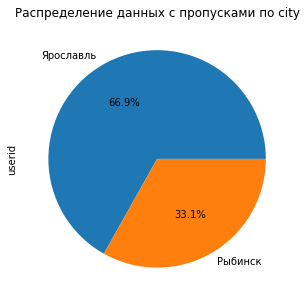

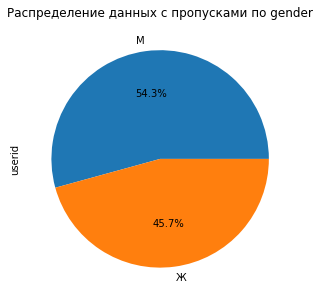

In [52]:
data_nan = data.query('balance != balance')
print('Первые строки данных с пропусками:')
display(data_nan.head())
print()
for i in ['city', 'gender']:
    data_nan.groupby(i).agg({'userid':'count'}).sort_values(by='userid', ascending=False).plot(y='userid', kind='pie', autopct='%0.01f%%', figsize=(5,5), title = "Распределение данных с пропусками по {}".format(i), legend=None)
plt.show()

* Пропуски в данных по балансу есть только в Ярославле и Рыбинске. В данных по Ростове Великом пропусков нет.   
Наибольшая часть пропущенных значений приходится на клиентов ярославских отделений банка.    
* 54,3% пропусков относятся к клиентам мужского пола и 45,7% к клиентам женского пола. 

Выгрузим характерные значения данных с пропусками по отдельно по Ярославлю и Рыбинску, чтобы выявить возможные взаимосвязи по территориальному признаку:

In [53]:
nan_yaroslavl = data_nan.query('city == "Ярославль"')
print('Характерные значения данных с пропусками по Ярославлю:')
display(nan_yaroslavl.loc[:,'score':'churn'].describe().T);

Характерные значения данных с пропусками по Ярославлю:


,count,mean,std,min,25%,50%,75%,max
score,2418.0,648.345740,96.885737,350.00,581.0000,651.000,716.0000,850.00
age,2418.0,38.404467,10.520316,18.00,31.0000,37.000,43.0000,85.00
objects,2418.0,5.064516,2.866058,0.00,3.0000,5.000,7.0000,10.00
balance,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
products,2418.0,1.781224,0.497934,1.00,1.0000,2.000,2.0000,4.00
creditcard,2418.0,0.719603,0.449286,0.00,0.0000,1.000,1.0000,1.00
loyalty,2418.0,0.521092,0.499658,0.00,0.0000,1.000,1.0000,1.00
estimated_salary,2418.0,99119.893565,57758.761656,90.07,49854.7275,98264.445,148525.3775,199909.32
churn,2418.0,0.139371,0.346405,0.00,0.0000,0.000,0.0000,1.00


In [54]:
nan_rybinsk = data_nan.query('city == "Рыбинск"')
print('Характерные значения данных с пропусками по Рыбинску:')
display(nan_rybinsk.loc[:,'score':'churn'].describe().T);

Характерные значения данных с пропусками по Рыбинску:


,count,mean,std,min,25%,50%,75%,max
score,1199.0,651.685571,94.676536,382.00,585.00,650.00,717.00,850.00
age,1199.0,38.496247,10.438777,18.00,32.00,37.00,43.00,88.00
objects,1199.0,5.085071,2.851254,0.00,3.00,5.00,8.00,10.00
balance,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
products,1199.0,1.791493,0.493593,1.00,2.00,2.00,2.00,4.00
creditcard,1199.0,0.710592,0.453677,0.00,0.00,1.00,1.00,1.00
loyalty,1199.0,0.511259,0.500082,0.00,0.00,1.00,1.00,1.00
estimated_salary,1199.0,98708.617389,57697.565204,417.41,48175.56,98820.09,147663.49,199992.48
churn,1199.0,0.135947,0.342875,0.00,0.00,0.00,0.00,1.00


Описательная статистика числовых столбцов среза с пропусками отличается от всего датасета несильно.  

**Посмотрим на частоту значений данных с пропусками на гистограмме:**

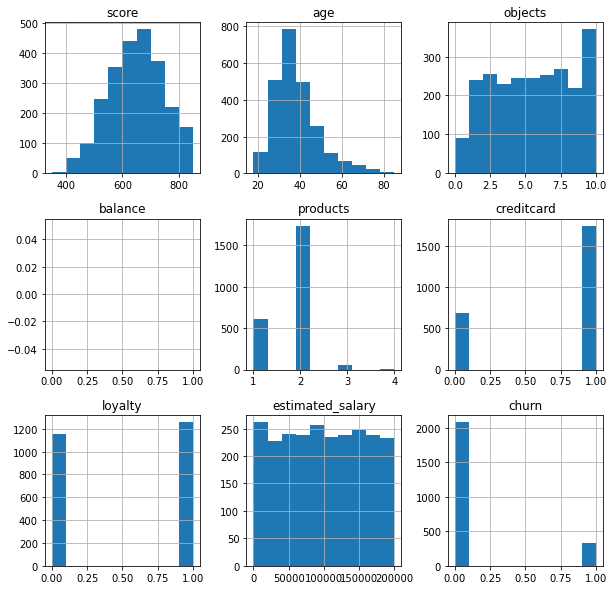

In [55]:
# отдельно по Ярославлю
nan_yaroslavl.loc[:,'score':'churn'].hist(figsize=(10,10));

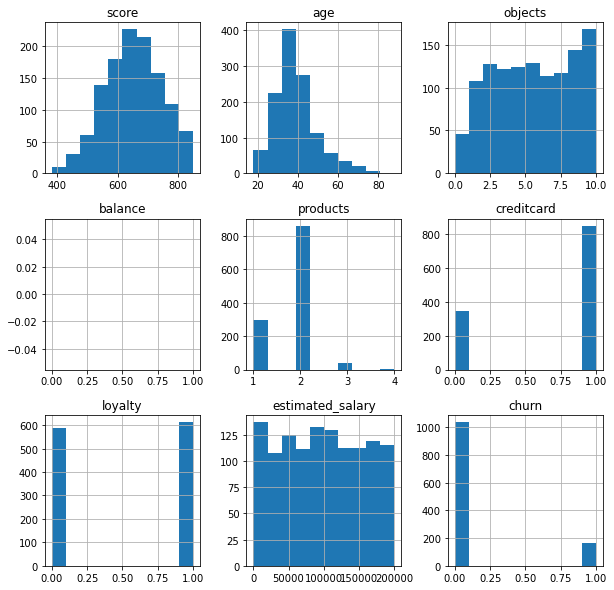

In [56]:
# отдельно по Рыбинску
nan_rybinsk.loc[:,'score':'churn'].hist(figsize=(10,10));

**Вывод**: С учётом того, что по данным клиентов из Ростова Великого пропусков нет, то в данных по Ярославлю и Рыбинску пропуски могут быть связаны с ошибками при заполнении данных сотрудниками или с техническим сбоем при загрузке/выгрузке датасета.

По гистограмме видим, что у большей части клиентов с пропусками есть кредитная карта, но не у всех. Нельзя однозначно утверждать, что пропуски означают отрицательный баланс. 

При этом, явных признаков того, что пропуски означают нулевой баланс нет, кроме того, что в данных нет клиентов с нулевым балансом (таких клиентов нет и в Ростове Великом)

По данным клиентам практически одинаково распределено количество активных и неактивных. Среди них большая часть не попали в отток и остаются клиентами банка. 

36,17% пропущенных данных - значительно, поэтому удалять строки не следует во избежание искажения результатов исследования. По этой же причине не будем заменять пропуски на 0, отрицательные значения, моду или медиану - данные в столбцах не связаны, нет оснований для замены значений. Таким образом, пропуски оставляем как есть. 

#### Проверка на выбросы
У столбцов - `creditcard`, `loyalty`,`churn` поля принимают значения 0 или 1. Выбросы не предполагаются.  
Столбцы `city`,`gender` принимают категориальные значения, по ним выбросы не смотрятся.  

Построим график «ящик с усами» и гистограммы для столбцов с числовыми значениями - `score`, `age`, `objects`, `balance`,`products`, `estimated_salary`.

In [57]:
# выгрузка характерных значений для рассматриваемых столбцов
data.loc[:, ['score','age','objects','balance','products','estimated_salary']].describe().T

,count,mean,std,min,25%,50%,75%,max
score,10000.0,650.528800,96.653299,350.00,584.000,652.000,718.0000,850.00
age,10000.0,38.921800,10.487806,18.00,32.000,37.000,44.0000,92.00
objects,10000.0,5.012800,2.892174,0.00,3.000,5.000,7.0000,10.00
balance,6383.0,119827.493793,30095.056462,3768.69,100181.975,119839.690,139512.2900,250898.09
products,10000.0,1.530200,0.581654,1.00,1.000,1.000,2.0000,4.00
estimated_salary,10000.0,100090.239881,57510.492818,11.58,51002.110,100193.915,149388.2475,199992.48


Диаграммам размаха столбца score:


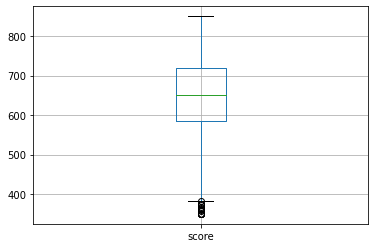

Гистограмма значений столбца score:


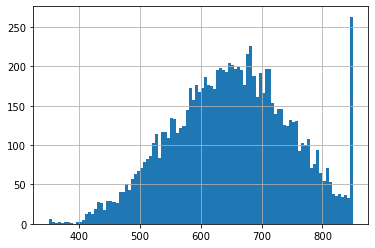

Диаграммам размаха столбца age:


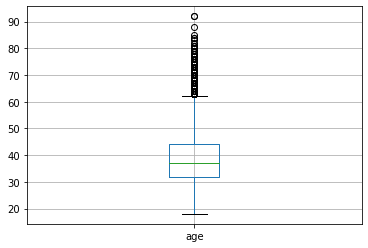

Гистограмма значений столбца age:


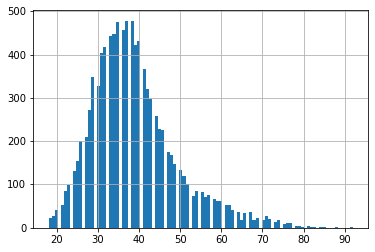

Диаграммам размаха столбца objects:


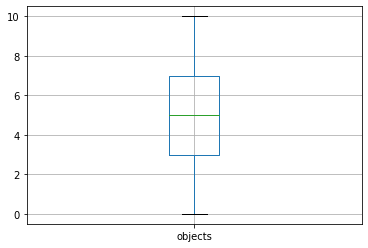

Гистограмма значений столбца objects:


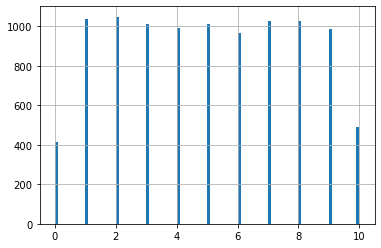

Диаграммам размаха столбца balance:


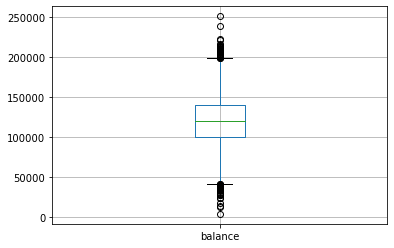

Гистограмма значений столбца balance:


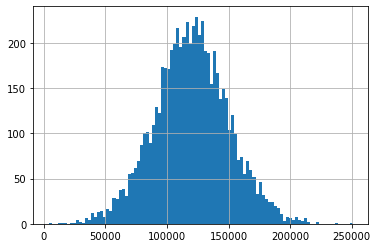

Диаграммам размаха столбца products:


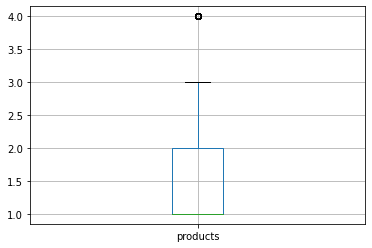

Гистограмма значений столбца products:


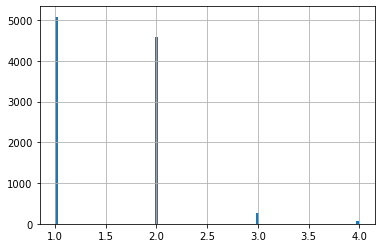

Диаграммам размаха столбца estimated_salary:


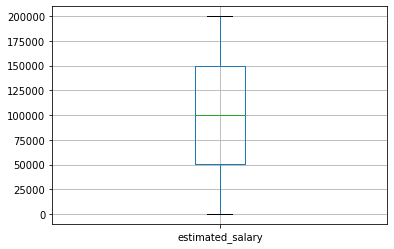

Гистограмма значений столбца estimated_salary:


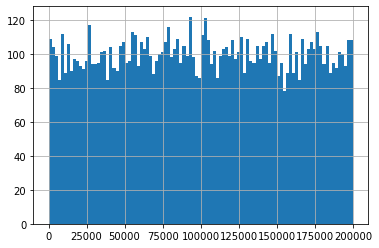

In [58]:
# Диаграммам размаха и Гистограмма значений столбцов с числовыми значениями 
for i in ['score','age','objects','balance','products','estimated_salary']:
    print('Диаграммам размаха столбца {}:'.format(i))
    data.boxplot(i)
    plt.show();
    print('Гистограмма значений столбца {}:'.format(i))
    data[i].hist(bins=100)
    plt.show();

По диаграммам размаха и гистограммам видим следующее:
- В столбце `estimated_salary` есть предельно низкие значения дохода (от 11,58р.), но все значения находятся в пределах усов. Со своей стороны можем предположить, что в данный столбец учитывается не только заработная плата, но и стипендии, пособии, % от вкладов.
- В столбце `objects` имеются значения от 0 до 10 объектов в собственности. Максимальное и минимальное значения встречаются реже остальных, но находятся в пределах усов.  

Выбросы можем отметить в столбцах:
- `score` - менее 400 баллов кредитного скоринга
- `age` - возраст более 75 лет
- `balance` - баланс на счете менее 50 000р. и более 200 000р.
- `products` - более 3х продуктов 

Аномальные значения в данных столбцах не похожи на ошибки ввода данных. Также предварительно непонятно как данные выбросы влияют на результат анализа. При этом данные могут быть информативны в отношении изучения оттока клиентов. Удалять из выборки данные не будем, а учтем их наличие в датасете и произведем разделение клиентов на категории. 

Диаграммам размаха столбца estimated_salary:


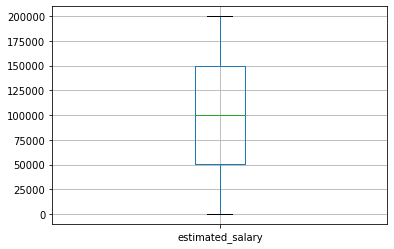

In [59]:
print('Диаграммам размаха столбца estimated_salary:')
data.boxplot('estimated_salary')
plt.show();

### Добавление новых столбцов для категориальных данных 'city' и 'gender'

In [60]:
data['gender_2'] = data['gender']

data = pd.get_dummies(data, columns = ['gender_2'])
data = data.rename(columns = ({'gender_2_Ж': 'woman', 'gender_2_М': 'man'}))

data['city_2'] = data['city']

data = pd.get_dummies(data, columns = ['city_2'])
data = data.rename(columns = ({'city_2_Ярославль': 'Yaroslavl', 'city_2_Рыбинск': 'Rybinsk', 'city_2_Ростов Великий':'Rosrov_V'}))

### Вывод по этапу предобработки данных

На этапе предобработки данных было сделано:
- приведение названий столбцов к нижнему регистру
- проверка данных на пропуски. Обнаружили пропуск 36.17% данных стоблце «баланс на счёте».  Во избежание искажения результатов исследования, пропуски не удалялись и не заменялись на иные значения
- проверка данных на выбросы показала наличие аномальных значений в стоблцах `score`, `age`,`balance`, `products`. Так как данные могут быть информативны в рамках рассматриваемой задачи, была решено не удалять выбросы, а учтесть их наличие, разделив клиентов на ряд категорий.
- для столбцов с категориальными значениями ('city' и 'gender') добавлены столбцы с числовыми значениями

## Исследовательский анализ данных

### Распределение оттока по параметрам

Посмотрим как распределены данные по оттоку. Для этого построим нормализованные гистограммы по всем параметрам.   
Это поможет нам выявить признаки оттока

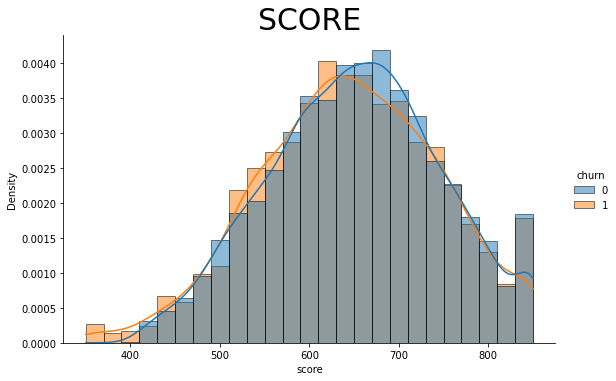

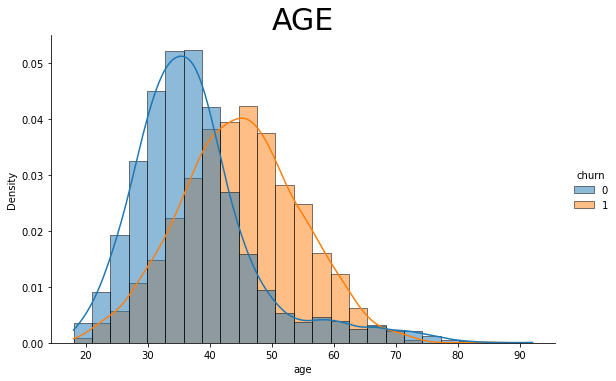

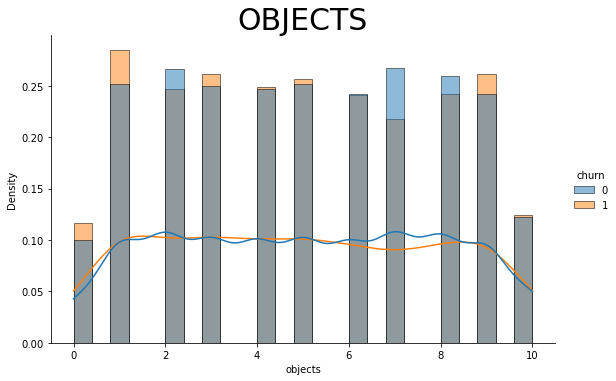

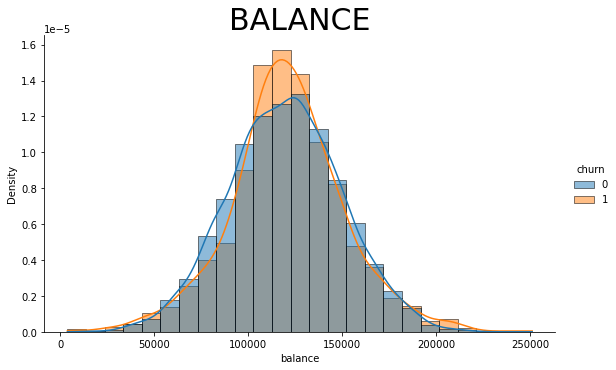

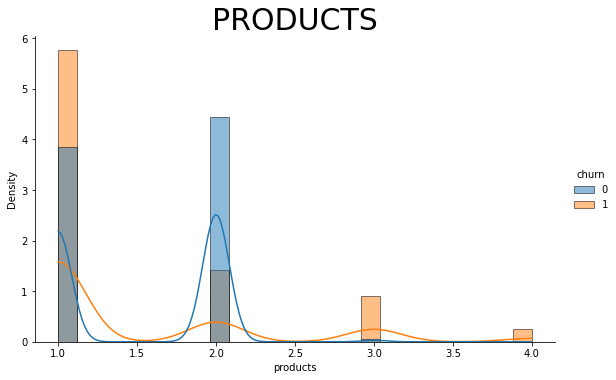

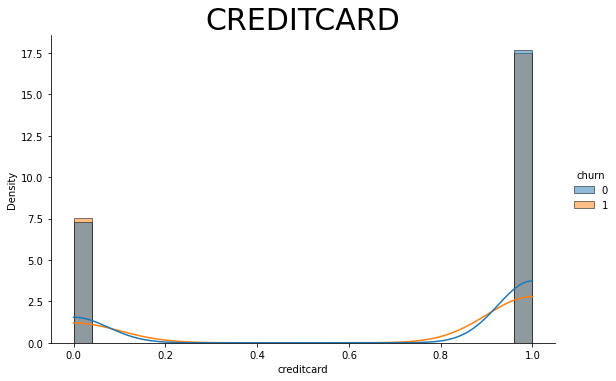

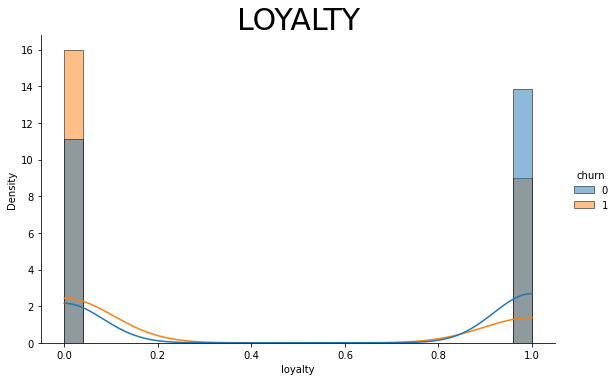

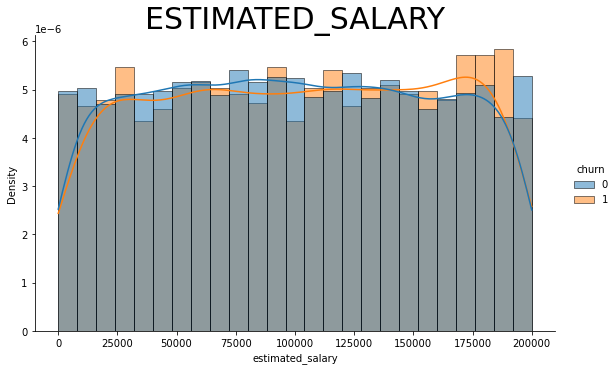

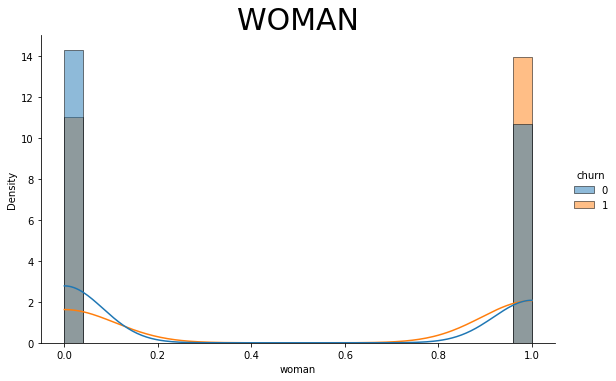

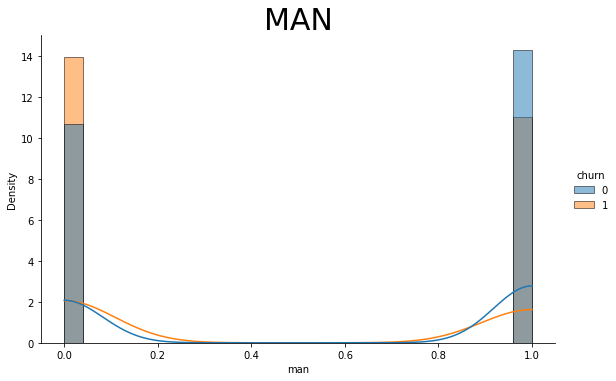

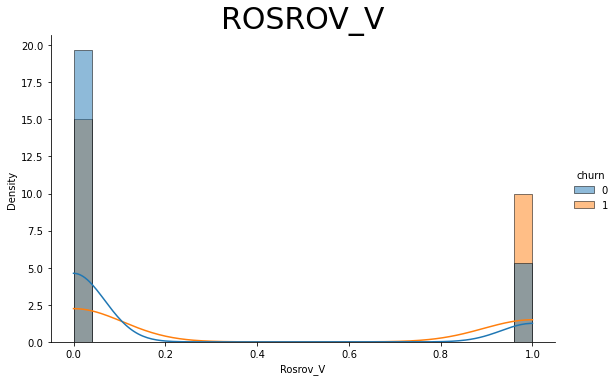

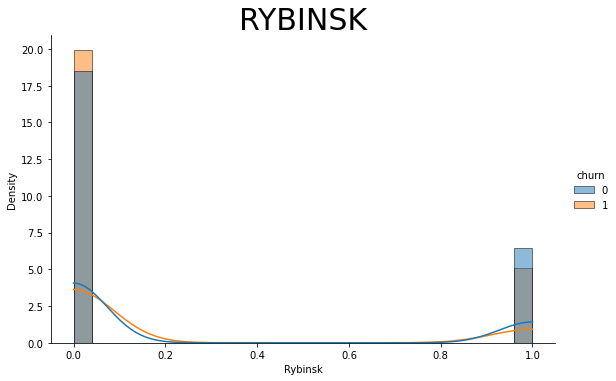

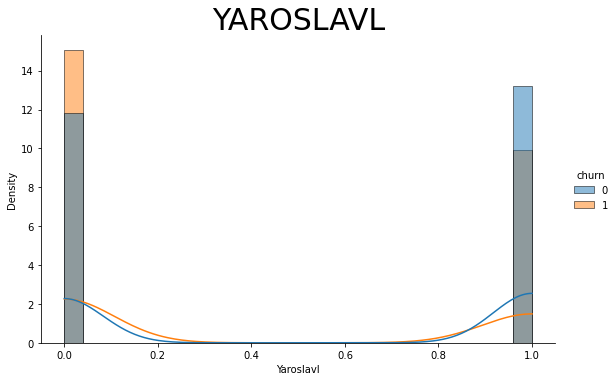

In [61]:
for i in data.columns:
    if i != 'userid' and i != 'city' and i != 'gender' and i != 'churn':
        sns.displot(
            data, x=i, hue='churn',
            linewidth=0.5, kde=True,
            stat="density", common_norm=False,
            height=5, aspect=1.6, bins=25)
        plt.title(i.upper(), fontsize=30)
        plt.show();

1) По графику баллов кредитного скоринга: у данных по оттоку есть хвост левее 450 баллов. До 650 баллов кривая плотности оттока находится выше кривой плотности не попадающих в отток. С увеличением количества баллов, от 650, плотность оттока клиентов снижается.

2) Хорошо видно, что графики отточных и неотточных клиентов по возрасту разъезжаются в разные стороны. Наибольшее количество неотточных клиентов находятся в возрасте 30-40 лет. До 40 лет кривая плотности неоточных клиентов выше, чем у клиентов в оттоке. Плотность оттока принимает наибольшие значения у клиентов в возрасте от 40 до 50 лет. При этом высокий отток  наблюдается у клиентов вплоть до 65 лет и только после становится ниже, чем у неотточных клиентов.

3) По количеству продуктов, видим закономерность: наиболее устойчивы клиенты с 2 банковскими продуктами. Среди клиентов с 1 продуктом отток заметный. А прочти все клиенты с 3-4 продуктами попадают в отток. 

4) Неактивные клиенты чаще попадают в отток, чем активные

5) Среди клиентов женщин отток выше, чем среди клиентов мужского пола

6) В Ростове Великом плотность оттока клиентов выше, а в Ярославле и Рыбинске такого не наблюдается.  

По количеству объектов недвижимости, балансу, наличию кредитной карты, зарплате - линии плотности практически повторяют друг друга

### Расчет общей доли оттока

In [62]:
#отберем клиентов, которые попали в отток. Для удобства анализа оставим только добавленные столбцы
print('Доля ушедших клиентов составляет: {:.2%} клиентов'.
      format(data.query('churn == 1')['userid'].count()/data['userid'].count()))

Доля ушедших клиентов составляет: 20.37% клиентов


### Рассчет доли оттока по категориям в параметрах, влияющих на отток

Рассчитаем долю оттока в категориях `score`, `age`, `products`, `loyalty`, `gender`, `city` и сравним с показателем общего оттока. Таким образом найдем высокооточные категории в параметрах.

Для начала значения столбцов `score`, `age` необходимо объединить в категории

#### Категории по баллам кредитного скоринга:  
Делить на категории будем на основании ранее построенного нормированного графика распределения:

По нему мы видели:
- высокая доля оттока была у клиентов с баллами кредитного скоринга ниже **450**.  
- Кривая плотности отточных клиентов была выше другой кривой до **650** баллов.   
- В значениях 650-**750** кривая оставшихся клиентов была выше, далее графики практически совпадали.   

По этим значениям и разделим клиентов  

(array([ 185., 4715., 3477., 1623.]),
 array([  0., 450., 650., 750., 850.]),
 <BarContainer object of 4 artists>)

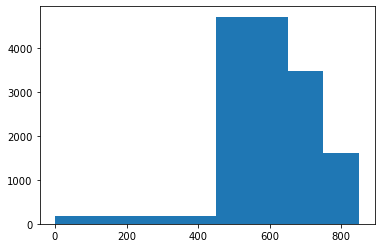

In [63]:
plt.hist(data['score'], [0.0, 450.0, 650.0, 750.0, 850.0])

Таким образом получаем категории:
1. до 450 баллов - 185 клиентов 
2. от 451 до 650 - 4715 клиентов 
3. от 651 до 750 - 3477 клиентов 
4. от 751 до 850 - 1623 клиентов 

In [64]:
#добавление столбца с разделением клиентов на категории по баллам 450, 650, 750, 850
def score_category(score):
    try:
        if 0 <= score <= 450:
            return 1
        elif 451 <= score <= 650:
            return 2
        elif 651 <= score <= 750:
            return 3
        elif score >= 751:
            return 4
    except:
        pass
    
data['score_category'] = data['score'].apply(score_category)

In [65]:
score_category = data.pivot_table(index ='score_category', values='churn', aggfunc=['count','sum']).reset_index()
score_category.columns = ['score_category', 'count', 'churn_1']
score_category['churn_0'] = score_category['count'] - score_category['churn_1']
score_category['churn_%'] = round(score_category['churn_1']/score_category['count']*100,2)
display(score_category)

score_category1 = data.groupby(['score_category','churn'])['userid'].count().reset_index().rename({'userid': 'count'}, axis=1)

,score_category,count,churn_1,churn_0,churn_%
0,1,189,61,128,32.28
1,2,4748,996,3752,20.98
2,3,3465,667,2798,19.25
3,4,1598,313,1285,19.59


К первой категории (от 0 до 450 баллов) относится мало клиентов, всего 189 человек, но из них 32% попадают в отток.   
В остальных категориях доля оттока близка к общему показателю.  

#### Категории по возрасту
Также будем делить клиентов на категории исходя из данных графика распределеня:

(array([1641., 4346., 3731.,  282.]),
 array([  0,  30,  40,  65, 100]),
 <BarContainer object of 4 artists>)

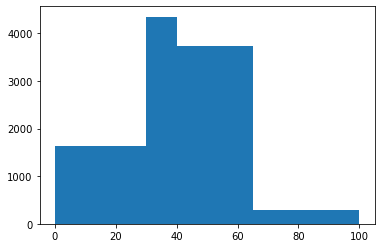

In [66]:
plt.hist(data['age'], [0, 30, 40, 65,100])

- до 30 лет - 1641 клиент
- от 31 до 40 лет - 4346 клиентов - на данный диапазон приходится наибольшее количество неотточных клиентов 
- от 41 до 65 лет - 3731 клиент - отток клиентов начинает превышать кривую неотточных клиентов
- более 65 лет - 282 клиента - кривая оттока клиентов становится ниже, чем у неотточных клиентов.

In [67]:
#добавление столбца с разделением клиентов на категории по возрасту
def age_category(age):
    try:
        if 0 <= age <= 30:
            return 1
        elif 31 <= age <= 40:
            return 2
        elif 41 <= age <= 65:
            return 3
        elif age >= 65:
            return 4
    except:
        pass
    
data['age_category'] = data['age'].apply(age_category)

In [68]:
age_category = data.pivot_table(index ='age_category', values='churn', aggfunc=['count','sum']).reset_index()
age_category.columns = ['age_category', 'count', 'churn_1']
age_category['churn_0'] = age_category['count'] - age_category['churn_1']
age_category['churn_%'] = round(age_category['churn_1']/age_category['count']*100,2)
display(age_category)

age_category1 = data.groupby(['age_category','churn'])['userid'].count().reset_index().rename({'userid': 'count'}, axis=1)

,age_category,count,churn_1,churn_0,churn_%
0,1,1968,148,1820,7.52
1,2,4451,538,3913,12.09
2,3,3317,1316,2001,39.67
3,4,264,35,229,13.26


В категории 3 (с возрастом клиентов от 41 до 65 лет) доля оттока составляет 39,7%. 
В остальных категориях отток ниже собщего значения. Особенно низкий отток наблюдается в 1 категории

#### Отток по другим показателям наиболее влияющим на отток
Рассчитаем долю оттока в параметрах 'products','loyalty', 'woman','Rosrov_V', 'Rybinsk', 'Yaroslavl'

In [69]:
for i in ['products','loyalty', 'woman','Rosrov_V', 'Rybinsk', 'Yaroslavl']:
    print('Доля оттока в параметре {}:'.format(i))
    i_category = data.pivot_table(index =i, values='churn', aggfunc=['count','sum']).reset_index()
    i_category.columns = [i, 'count', 'churn_1']
    i_category['churn_0'] = i_category['count'] - i_category['churn_1']
    i_category['churn_%'] = round(i_category['churn_1']/i_category['count']*100,2)
    display(i_category)
    i_category1 = data.groupby([i,'churn'])['userid'].count().reset_index().rename({'userid': 'count'}, axis=1)
    print()

Доля оттока в параметре products:


,products,count,churn_1,churn_0,churn_%
0,1,5084,1409,3675,27.71
1,2,4590,348,4242,7.58
2,3,266,220,46,82.71
3,4,60,60,0,100.00



Доля оттока в параметре loyalty:


,loyalty,count,churn_1,churn_0,churn_%
0,0,4849,1302,3547,26.85
1,1,5151,735,4416,14.27



Доля оттока в параметре woman:


,woman,count,churn_1,churn_0,churn_%
0,0,5457,898,4559,16.46
1,1,4543,1139,3404,25.07



Доля оттока в параметре Rosrov_V:


,Rosrov_V,count,churn_1,churn_0,churn_%
0,0,7491,1223,6268,16.33
1,1,2509,814,1695,32.44



Доля оттока в параметре Rybinsk:


,Rybinsk,count,churn_1,churn_0,churn_%
0,0,7523,1624,5899,21.59
1,1,2477,413,2064,16.67



Доля оттока в параметре Yaroslavl:


,Yaroslavl,count,churn_1,churn_0,churn_%
0,0,4986,1227,3759,24.61
1,1,5014,810,4204,16.15


**Вывод**:

Доля ушедших клиентов составляет: 20.37% клиентов

По построенным графикам и таблицам мы увидели, что для клиентов, попадающих в отток характерны определенные признаки.

`score` - к первой категории (от 0 до 450 баллов) относится мало клиентов, всего 189 человек, но из них 32% попадают в отток.
В остальных категориях доля оттока близка к общему показателю. Параметр не будем далее включать в портрет клиентов, так как наиболее отточная категория включает всего 2% клиентов

`age` - в категории 3 (с возрастом клиентов от 41 до 65 лет) доля оттока составляет **39,7%**. В остальных категориях отток ниже среднего, особенно в 1 категории

`products` - высокая доля оттока у клиентов с количеством продуктов **1 (28%), 3 (83%) и 4 (100%)**. Наиболее устойчивы клиенты с 2 продуктами.

`loyalty` - доля оттока у неактивных клиентов  — 26,85%. Доля оттока у активных клиентов - 14%
 
`gender` - доля оттока среди женщин — 25,07%, а среди мужчин только 16%

`city`  - доля оттока в Ростове составляет **32,44%**. В Рыбинске и в Ярославле отток только 16-17%

### 3.4. Составление матрицы корреляции 

Рассчитаем коэффициенты корреляции, чтобы увидеть наличие связи между параметрами.  

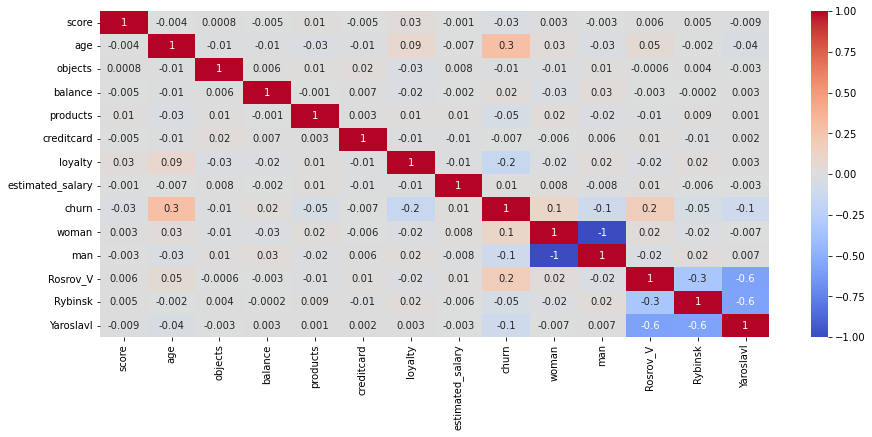

In [70]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.heatmap(data.loc[:,'score':'Yaroslavl'].corr(), annot = True, fmt='.1g',cmap= 'coolwarm');

По шкале Чеддока связь считается: слабой при коэффициенте 0.1-0.3, умеренной при коэффициенте 0.3-0.5

**Умеренная прямая прямая** связь наблюдается только между возрастом и оттоком - коэффициент 0.3

**Слабая прямая связь** наблюдается между параметрами:
1. отток и клиенты из города Ростов Великий - коэффициент 0.2
2. отток и клиенты женского пола - коэффициент 0.1
3. активность и возраст - коэффициент 0.09 
3. возраст и клиенты из Ростова Великого - коэффициент 0.05

**Слабая обратная связь** наблюдается между параметрами:
1. активность и отток - коэффициент -0.2 (неактивный клиент вероятнее попадёт в отток, чем активный нет)
2. отток и клиенты мужского пола - коэффициент -0.1
3. отток и клиенты из Ярославля (коэффициент -0.1) и Рыбинска (коэффициент -0.05) 
4. отток и количество продуктов - коэффициент -0.05

Связи между остальными параметрами практически нет. 

### Портрет клиентов, которые попали в отток

Таким образом, у нас получились 5 параметров, наиболее влияющих на отток. 
* `products` - клиенты с числом банковских продуктов: 1 (отток 28%), 3 (отток 83%), 4 (отток 100%) 
* `age` - возраст от 40 до 65 лет, то есть `age_category` = 3 - отток 40%
* `city` - клиенты из Ростова Великого - `Rosrov_V` = 1 (отток 32,4%)
* `loyalty` - 0, неактивные клиенты (отток 26,85%)
* `gender` - клиенты женского пола - `woman` = 1 (отток 25%)

**Портрет клиентов попадающих в отток**: клиенты женского пола из Ростова Великого в возрасте от 40 до 65 лет с 1-3-4 банковскими продуктами, у которых за последний месяц не было взаимодействий с банком.

In [71]:
churn_portrait = data.query(
    'products != 2 and \
    age_category == 3 and \
    Rosrov_V == 1 and \
    loyalty == 0 and \
    woman == 1')
print('Количество клиентов:', churn_portrait['userid'].count())
print('Доля от всех клиентов банка %:', round(churn_portrait['userid'].count()/data['userid'].count()*100,2))
print('Количество отточных клиентов:', churn_portrait.query('churn ==1')['userid'].count())
print('Процент оттока %:', round(churn_portrait.query('churn ==1 ')['userid'].count()/churn_portrait['userid'].count()*100,2))

Количество клиентов: 202
Доля от всех клиентов банка %: 2.02
Количество отточных клиентов: 160
Процент оттока %: 79.21


Клиентов, соответствующих всем признакам оттока немного - 202 человека. Но среди них, доля оттока достигает 79%.  
При исключении признаков оттока, количество клиентов в выборке будет увеличиваться, но уменьшеньшится доля оттока.

Наиболее отточны и многочисленны выборки сочетающие 3 признака:
- количество продуктов не равно двум
- возрастная категория 3
- неактивные клиенты

In [72]:
churn_portrait = data.query(
    'products != 2 and \
    age_category == 3 and\
    loyalty == 0')
print('Количество клиентов:', churn_portrait['userid'].count())
print('Доля от всех клиентов банка %:', round(churn_portrait['userid'].count()/data['userid'].count()*100,2))
print('Количество отточных клиентов:', churn_portrait.query('churn ==1')['userid'].count())
print('Процент оттока %:', round(churn_portrait.query('churn ==1 ')['userid'].count()/churn_portrait['userid'].count()*100,2))

Количество клиентов: 1081
Доля от всех клиентов банка %: 10.81
Количество отточных клиентов: 726
Процент оттока %: 67.16


А также:
- количество продуктов не равно двум
- возрастная категория 3
- женщины

In [73]:
churn_portrait = data.query(
    'products != 2 and \
    age_category == 3\
    and woman == 1')
print('Количество клиентов:', churn_portrait['userid'].count())
print('Доля от всех клиентов банка %:', round(churn_portrait['userid'].count()/data['userid'].count()*100,2))
print('Количество отточных клиентов:', churn_portrait.query('churn ==1')['userid'].count())
print('Процент оттока %:', round(churn_portrait.query('churn ==1 ')['userid'].count()/churn_portrait['userid'].count()*100,2))

Количество клиентов: 995
Доля от всех клиентов банка %: 9.95
Количество отточных клиентов: 598
Процент оттока %: 60.1


### Портрет клиентов, которые не попали в отток

**Портрет клиентов не попадающих в отток**: клиенты мужского пола из Рыбинска или Ярославля в возрасте до 40 или старше 65 лет с 2 банковскими продуктами, у которого была активность в банке за последние 30 дней

Параметры у таких клиентов чаще принимают значения:
* `age` — возраст до 40 лет или старше 65 лет 
* `products` - клиенты с 2 банковскими продуктами
* `loyalty` - активные клиенты
* `gender` - клиенты мужского пола
* `city` - клиенты из Рыбинска или Ярославля

In [74]:
churn_portrait = data.query(
    'products == 2 and \
    age_category != 3 and \
    Rosrov_V != 1 and \
    loyalty == 1 and \
    man == 1')
print('Количество клиентов:', churn_portrait['userid'].count())
print('Доля от всех клиентов банка %:', round(churn_portrait['userid'].count()/data['userid'].count()*100,2))
print('Количество отточных клиентов:', churn_portrait.query('churn ==1')['userid'].count())
print('Процент оттока %:', round(churn_portrait.query('churn ==1 ')['userid'].count()/churn_portrait['userid'].count()*100,2))

Количество клиентов: 748
Доля от всех клиентов банка %: 7.48
Количество отточных клиентов: 13
Процент оттока %: 1.74


Клиентов, соответствующих всем признакам низкой отточности - 748 человек. Среди них доля оттока составляет 1,7%. 
При исключении признаков оттока, количество клиентов в выборке будет увеличиваться, но увеличиваться доля оттока.

Наименее отточна и многочисленна выборка сочетающая 3 признака:
- количество продуктов - 2
- возрастная категория до 40 и старше 65 лет
- клиенты из Рыбинска или Ярославля

In [75]:
churn_portrait = data.query(
    'products == 2 and \
    age_category != 3 and \
    Rosrov_V != 1')
print('Количество клиентов:', churn_portrait['userid'].count())
print('Доля от всех клиентов банка %:', round(churn_portrait['userid'].count()/data['userid'].count()*100,2))
print('Количество отточных клиентов:', churn_portrait.query('churn ==1')['userid'].count())
print('Процент оттока %:', round(churn_portrait.query('churn ==1 ')['userid'].count()/churn_portrait['userid'].count()*100,2))

Количество клиентов: 2607
Доля от всех клиентов банка %: 26.07
Количество отточных клиентов: 89
Процент оттока %: 3.41


### Вывод по этапу исследовательского анализа данных

На данном этапе мы рассмотрели каждый параметр в разрезе распределения данных по клиентам попавшим и не попавшим в отток. 
На графиках увидели, что в параметрах : `score`,`age`, `products`, `loyalty`, `gender`, `city` расходятся линии плотности и на интервалах возрастала доля отточных клиентов.   
Признаки и были определены как наиболее влияющие на отток и для них выделили категории.

Далее мы рассчитали общую долю ушедших клиентов - 20.37%  и долю оттока в выделенных категориях:  

`score` - до 650 баллов кривая плотности оттока находится выше кривой плотности не попадающих в отток. От 650, плотность оттока клиентов снижается. 32% клиентов 1 категории (до 450 баллов) попадают в отток, но так в категорию входят всего 2% клиентов, признак не будем рассматривать далее. Отток по остальным категориям равнозначен значению общего оттока.  

`age` - в категории 3 (с возрастом клиентов от 41 до 65 лет) доля оттока составляет 39,7%. В остальных категориях отток ниже среднего, особенно в 1 категории (7,5%)  

`products` - высокая доля оттока у клиентов с количеством продуктов 1 (28%), 3 (83%) и 4 (100%). Наиболее устойчивы клиенты с 2 банковскими продуктами.  

`loyalty` - доля оттока у неактивных клиентов — 26,85%. Доля оттока у активных клиентов - 14%  

`gender` - доля оттока среди женщин — 25,07%, а среди мужчин только 16%  

`city` - доля оттока в Ростове составляет 32,44%. В Рыбинске и в Ярославле отток только 16-17%  

Составив матрицу корреляции, мы убедились в наличии:
- умеренной  прямой связи между *возрастом и оттоком*; 
- слабой прямой связь между: *оттоком и клиентами из Ростова Великого / клиентами женского пола*, между *возрастом и клиентами из Ростова Великого / активностью*. 
- Слабая обратная связь наблюдается между *оттоком и активностью, клиентами мужского пола, клиентами не из Ростова Великого и количеств продуктов*. 

В результате мы определили 5 наиболее отточных категорий и по ним составили портреты клиентов:

**Портреты клиентов,попадающих в отток:**

- Портрет клиентов попадающих в отток №1. Количество клиентов: 202. Процент оттока %: 79.21: клиенты женского пола из Ростова Великого в возрасте от 40 до 65 лет с 1-3-4 банковскими продуктами, у которых за последний месяц не было взаимодействий с банком. 

- Портрет клиентов попадающих в отток №2. Количество клиентов: 1081. Процент оттока %: 67.16: клиенты в возрасте от 40 до 65 лет с 1-3-4 банковскими продуктами, у которых за последний месяц не было взаимодействий с банком. 

- Портрет клиентов попадающих в отток №3. Количество клиентов: 995. Процент оттока %: 60.1: клиенты женского пола в возрасте от 40 до 65 лет с 1-3-4 банковскими. 


**Портреты клиентов не попадающих в отток:** 

- Портрет клиентов не попадающих в отток №1. Количество клиентов: 748. Процент оттока %: 1.74: клиенты мужского пола из Рыбинска или Ярославля в возрасте до 40 или старше 65 лет с 2 банковскими продуктами, у которого была активность в банке за последние 30 дней. 

- Портрет клиентов не попадающих в отток №2. Количество клиентов: 2607. Процент оттока %: 3.41:клиенты из Рыбинска или Ярославля в возрасте до 40 или старше 65 лет с 2 банковскими продуктами. 

## Проверка гипотез

### Гипотеза 1: 

* Нулевая гипотеза: различия в доходах между клиентами, которые ушли и которые остались, нет  
* Альтернативная гипотеза: различия в доходах между клиентами, которые ушли и которые остались, есть

Для выбора метода проверки гипотез о различии в доходах между ушедшими и оставшимися клиентами, сначала необходимо **проверить данные на нормальность**.

Для этого, применим критерий *Шапиро-Уилка*. Сформулируем гипотезы:  
* Нулевая: распределение нормально  
* Альтернативная: распределение не нормально

In [76]:
salary_churn_1 = data.query('churn ==1')['estimated_salary']
salary_churn_0 = data.query('churn ==0')['estimated_salary']

alpha = 0.05  # критический уровень статистической значимости

results1 = st.shapiro(salary_churn_1)
results2 = st.shapiro(salary_churn_0)
p_value1 = results1[1] 
p_value2 = results2[1]
print('Порог статистической значимости alpha =', alpha)
print()
print('p-значение: ', p_value1)
if p_value1 < alpha:
    print('Отвергаем нулевую гипотезу: распределение доходов ушедших клиентов не нормально')
else:
    print('Не получилось отвергнуть нулевую гипотезу, распределение доходов ушедших клиентов нормально') 
print()
print('p-значение: ', p_value2)    
if p_value2 < alpha:
    print('Отвергаем нулевую гипотезу: распределение доходов оставшихся клиентов не нормально')
else:
    print('Не получилось отвергнуть нулевую гипотезу, распределение доходов оставшихся клиентов нормально') 

Порог статистической значимости alpha = 0.05

p-значение:  4.594104044877579e-25
Отвергаем нулевую гипотезу: распределение доходов ушедших клиентов не нормально

p-значение:  3.797518838320254e-43
Отвергаем нулевую гипотезу: распределение доходов оставшихся клиентов не нормально


Так как распределение не нормально, для проверки гипотезы применим непараметрический тест - **U-критерий Манна-Уитни**:
* Нулевая гипотеза: различия в доходах между клиентами, которые ушли и которые остались, нет
* Альтернативная гипотеза: различия в доходах между клиентами, которые ушли и которые остались, есть  

In [77]:
alpha = 0.05  # критический уровень статистической значимости

results = st.mannwhitneyu(salary_churn_1, salary_churn_0)
print('Порог статистической значимости alpha =', alpha)
print('p-значение: {0:.3f}'.format(results.pvalue))
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу - разница доходов ушедших и оставшихся клиентов статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии доходов ушедших и оставшихся клиентов сделать нельзя'
    ) 

Порог статистической значимости alpha = 0.05
p-значение: 0.227
Не получилось отвергнуть нулевую гипотезу, вывод о различии доходов ушедших и оставшихся клиентов сделать нельзя


**Вывод:** Проверка гипотезы подтверждает, что различия в доходах между клиентами, которые ушли и которые остались, нет. 

### Гипотеза 2: 
* Нулевая гипотеза: средний балл кредитного скоринга между клиентами, которые ушли и которые остались, не отличается
* Альтернативная гипотеза: средний балл кредитного скоринга между клиентами, которые ушли и которые остались, отличается

Перед проверкой гипотез о равенстве средних баллов кредитного скоринга между ушедшими и оставшимися клиентами необходимо сначала проверить, **имеют ли выборки распределение близкое к нормальному**. Для этого, проведем тест Шапиро-Уилка.

* Нулевая гипотеза: распределение не нормально
* Альтернативная гипотеза: распределение не нормально

In [78]:
score_churn_1 = data.query('churn ==1')['score']
score_churn_0 = data.query('churn ==0')['score']

alpha = 0.05  # критический уровень статистической значимости

results3 = st.shapiro(score_churn_1)
p_value3 = results3[1] 

results4 = st.shapiro(score_churn_0)
p_value4 = results4[1]
                      
print('Порог статистической значимости alpha =', alpha)
print()
print('p-значение: ', p_value3)
if p_value3 < alpha:
    print('Отвергаем нулевую гипотезу: распределение доходов ушедших клиентов не нормально')
else:
    print('Не получилось отвергнуть нулевую гипотезу, распределение доходов ушедших клиентов нормально') 
print()
print('p-значение: ', p_value4)    
if p_value4 < alpha:
    print('Отвергаем нулевую гипотезу: распределение доходов оставшихся клиентов не нормально')
else:
    print('Не получилось отвергнуть нулевую гипотезу, распределение доходов оставшихся клиентов нормально') 

Порог статистической значимости alpha = 0.05

p-значение:  1.2323278042458696e-07
Отвергаем нулевую гипотезу: распределение доходов ушедших клиентов не нормально

p-значение:  1.469723138650797e-19
Отвергаем нулевую гипотезу: распределение доходов оставшихся клиентов не нормально


Распределение данных не нормально, поэтому для проверки гипотезы снова применим **непараметрический тест - U-критерий Манна-Уитни**:

* Нулевая гипотеза: средний балл кредитного скоринга между клиентами, которые ушли и которые остались, не отличается
* Альтернативная гипотеза: средний балл кредитного скоринга между клиентами, которые ушли и которые остались, отличается

In [79]:
# results = вызов метода для проверки гипотезы
results = st.ttest_ind(score_churn_0, score_churn_1, equal_var=True)
# alpha = задайте значение уровня значимости
alpha = 0.05

# вывод значения p-value на экран 
print('Порог статистической значимости alpha =', alpha)
print('p-value = {0:.3f}'.format(results.pvalue)) 

# условный оператор с выводом строки с ответом
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу - разница среднего балла у клиентов, которые ушли и которые остались, статистически значима')
else:
    print('Не получилось отвергнуть нулевую гипотезу - вывод о различии среднего балла между клиентами, которые ушли и которые остались, сделать нельзя')

Порог статистической значимости alpha = 0.05
p-value = 0.007
Отвергаем нулевую гипотезу - разница среднего балла у клиентов, которые ушли и которые остались, статистически значима


**Вывод**: Двустороннее значение p = 0.007, меньше порога статистической значимости alpha = 0.05, поэтому отвергаем нулевую гипотезу теста - разница среднего балла у клиентов, которые ушли и которые остались, статистически значима.

### Выводы по этапу проверки гипотез

Проверки гипотез согласуются с ранее сделанными нами выводами на этапе исследовательского анализа данных:
- различий в доходах между клиентами, которые ушли и которые остались, нет. То есть заработная плата не относится к параметрам, влияющим на отток 
- средний балл кредитного скоринга между клиентами, которые ушли и которые остались, отличается. На построенных ранее графиках было видно: у клиентов с баллами кредитного скоринга менее 650 доля оттока выше, чем у клиентов с более высокими баллами (с увеличением количества баллов, плотность оттока клиентов снижается).

## Выводы по проекту
Мы изучили данные клиентов банка «Метанпром». Данные представлены по 10 000 клиентам в виде 12 параметров. 

**На этапе предобработки данных** мы привели названия столбцов к нижнему регистру, удостоверились в отсутствии явных и неявных дубликатов, изучили характер пропусков и выбросов и приняли решение не удалять их, добавили столбцы с бинарными значениями для категориальных данных.

**На этапе исследовательского анализа данных**  мы рассмотрели распределение отточных и неотточных клиентов по каждому параметру и выявили 6 признаков, наиболее влияющих на отток: `score`, `age`, `products`, `loyalty`, `gender`, `city`. 
Для признаков выделили категории, рассчитали долю оттока по каждой категории и определили наиболее отточные категории клиентов.  

Составивили матрицу корреляции и определили наличие умеренной прямой связи между возрастом и оттоком; слабой прямой связь между: оттоком и клиентами из Ростова Великого / клиентами женского пола, между возрастом и клиентами из Ростова Великого / активностью; слабой обратной связи между оттоком и активностью / клиентами мужского пола / клиентами не из Ростова Великого / количеством продуктов.

В результате мы составили портреты клиентов по наиболее отточным категориям параметров. 

Больше всего клиентов с высокой долей оттока: 
* в возрасте от 40 до 65 лет с 1-3-4 банковскими продуктами, у которых за последний месяц не было взаимодействий с банком (1081 клиент с 67% оттока). 
- женщины в возрасте от 40 до 65 лет с 1-3-4 банковскими (995 клиент с 60% оттока).


Больше всего клиентов с низкой долей оттока: 
- из Рыбинска или Ярославля в возрасте до 40 лет или старше 65 лет с 2 банковскими продуктами (2607 клиентов с 3,4% оттока). 

**Проверка гипотез** показала, что:
- различий в доходах между клиентами, которые ушли и которые остались, нет.
- средний балл кредитного скоринга между клиентами, которые ушли и которые остались, отличается. Из-за малого количества клиентов в отточной категории по `score`, признак решили не включать в портрет. 


## Рекомендации для Заказчика исследования

Клиентам женского пола и клиентам от 40 до 65 лет с 1 продуктом стоит предложить дополнительную услугу банка, наиболее подходящую их образу жизни. Продукт должен закрывать потребность клиента и постоянно им использоваться. 
Например, первый продукт - дебетовый (текущий счет /накопительный счет/вклад), второй продукт - кредитный (кредитная карта/кредит/ипотека). Так как у таких клиентов предполагается наличие стабильного дохода, семьи и сложившихся потребительских привычек, их можно удержать специальными условиями: % по депозиту, повышенным кэшбеком на определенные расходы (связанные с детьми, бытом, домом), оплата коммуналки без %, давать специальные условия обслуживания при открытии второго продукта, предложить выгодное рефинансирование кредитов. 

При этом, стоит обратить внимание на клиентов с 3 и более продуктами, отслеживать их уровень лояльности. 
Возможно, у банка есть несколько сильных продуктов, которыми клиенты довольны. Далее они решают попробовать новый и разачаровываются. Стоит составить рейтинг удовлетворенности продуктами, определить слабые и сильные места в продуктовой линейке банка. 
Также дополнительные банковские услуги могут быть навязаны при оформлении другого продукта. Чаще всего такие услуги не используются, но у клиента растет стоимость обслуживания (за счёт множества продуктов), что вызывает негатив.  

Кроме этого, банку стоит привлекать новых клиентов из категории от 18 до 40 лет (с низким показателем оттока). Таким клиентам могут быть интересны кредитные, инвестиционные продукты, технологичные решения банка (мобильный банкинг). 

Важно поддерживать активность и вовлеченность клиентов: предлагать выбор категорий кэшбека, выпускать продукты, мотивирующие совершать больше транзакций, улучшать удобство приложения и интернет-банк, особенно платежи и переводы. 

Дополнительно необходимо провести исследование причины высокой отточности клиентов именно в Ростове Великом, так как подобной тенденции в Рыбинске (с похожим количеством клиентов) и в Ярославе нет. Следует сравнить условия продуктов, качество клиентского сервиса, сделать анализ внешних факторов и сравнить с данными по другим городам.  